# **Open Circuit Potential (OCP) Balancing**

This notebook is created to provide an example of using PyBaMM-param package when balancing OCP curve with shifting and stretching the fitted curve to experimental data. This can also be found in `scripts/ocp_balance.py` as Python function.

In [1]:
#%pip install git+https://github.com/paramm-team/pybamm-param.git -q
import pbparam
import pandas as pd
import os

os.chdir(os.path.join(pbparam.__path__[0], "input", "data"))

We have 4 different files in this example. 2 for half-cell and 2 for three-electrode full cell. They are divided for their lithiation and delithiation stage.

In [2]:
#  .csv files are uploaded
anode_half_lit = pd.read_csv(os.path.join("anode_OCP_2_lit.csv"))
anode_half_delit = pd.read_csv(os.path.join("anode_OCP_2_delit.csv"))
anode_three_lit = pd.read_csv(os.path.join("anode_OCP_3_lit.csv"))
anode_three_delit = pd.read_csv(os.path.join("anode_OCP_3_delit.csv"))

In [3]:
#  .csv files are uploaded
cathode_half_lit = pd.read_csv(os.path.join("cathode_OCP_2_lit.csv"))
cathode_half_delit = pd.read_csv(os.path.join("cathode_OCP_2_delit.csv"))
cathode_three_lit = pd.read_csv(os.path.join("cathode_OCP_3_lit.csv"))
cathode_three_delit = pd.read_csv(os.path.join("cathode_OCP_3_delit.csv"))

Then, optimisation problem should be passed to pbparam with the data to be used as below. Cost function (default=pbparam.RMSE()) and weights (default=[1,1]) are optional arguments. Weights can be defined as single value list or same lengt with data.

In [3]:
ocp_balance = pbparam.OCPBalance(
    [anode_half_lit, anode_half_delit],
    [anode_three_lit, anode_three_delit],
    
    cost_function=pbparam.MLE(),
    #weights=[2],
)

[0      0.913911
1      0.672703
2      0.590480
3      0.526171
4      0.482013
         ...   
257    0.081076
258    0.080484
259    0.078115
260    0.078230
261    0.077199
Name: Voltage [V], Length: 262, dtype: float64, 0      0.077199
1      0.081019
2      0.082929
3      0.084208
4      0.085813
         ...   
249    0.506289
250    0.518379
251    0.546379
252    0.557437
253    0.577836
Name: Voltage [V], Length: 254, dtype: float64]


In [4]:
ocp_balance = pbparam.OCPBalance(
    [cathode_half_lit, cathode_half_delit],
    [cathode_three_lit, cathode_three_delit],
    
    cost_function=pbparam.MLE(),
    #weights=[2],
)

[0      4.280362
1      4.269052
2      4.259998
3      4.251555
4      4.243416
         ...   
249    3.563481
250    3.562144
251    3.559851
252    3.558323
253    3.556776
Name: Voltage [V], Length: 254, dtype: float64, 0      3.507662
1      3.543976
2      3.549574
3      3.553337
4      3.555190
         ...   
257    4.248899
258    4.255738
259    4.264793
260    4.271746
261    4.280362
Name: Voltage [V], Length: 262, dtype: float64]


Optimiser to minimise cost function should be selected in the nest step as below.

In [5]:
#optimiser = pbparam.ScipyMinimize(method="Nelder-Mead")
optimiser = pbparam.ScipyDifferentialEvolution()

```optimiser.optimise(optimisation_problem)``` should be used to run minimasiation algorithm.

In [6]:
result = optimiser.optimise(ocp_balance)

shift and stretch values and final cost function value can be printed as below.

In [7]:
print(result)


             Optimal values: [1.1        1.13965196 0.23592968 0.25354786]
        Cost function value: 5.315897503177027
                 Solve time: 3.471 s
                    Message: Optimization terminated successfully.
        


PyBaMM-param has built in plot function to represent results.

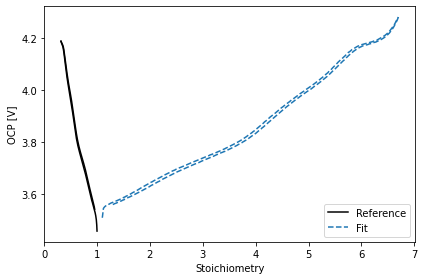

In [8]:
result.plot();